In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Changing directory to My Drive/Internship
%cd /content/drive/My\ Drive/Internship

/content/drive/My Drive/Internship


### Importing Required Libraries

In [ ]:
!pip install langdetect
!pip install deep_translator
!pip install nltk
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=ea8608a7602770bedb90e5b0a3780d3ece95dc59aeb613a38b5d5e331b230bb8
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import re
import nltk
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras import backend as K
from deep_translator import GoogleTranslator
from langdetect import detect, DetectorFactory

### Downloading necessary NLTK data

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Loading dataset

In [ ]:
data = pd.read_csv('full_data.csv')

In [ ]:
data.columns

Index(['title', 'custom_audience_persona', 'custom_cdo_cio_cto'], dtype='object')

### EDA: Category distribution

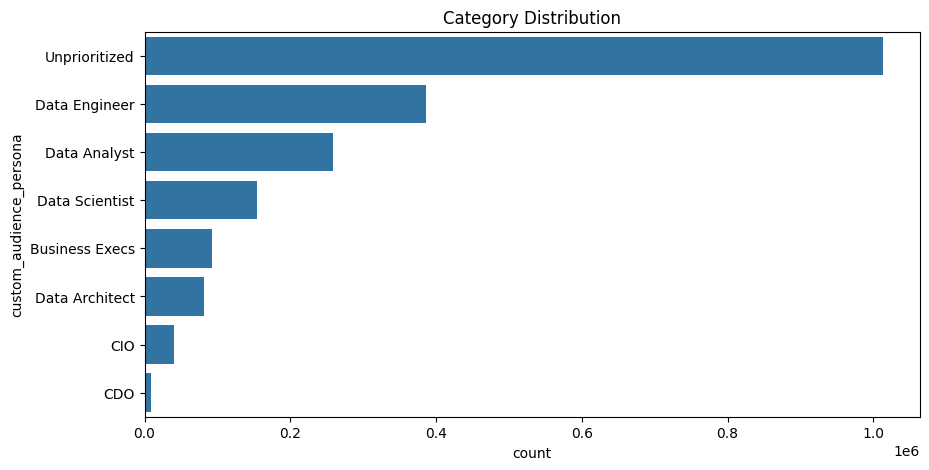

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(y=data['custom_audience_persona'], order=data['custom_audience_persona'].value_counts().index)
plt.title('Category Distribution')
plt.show()

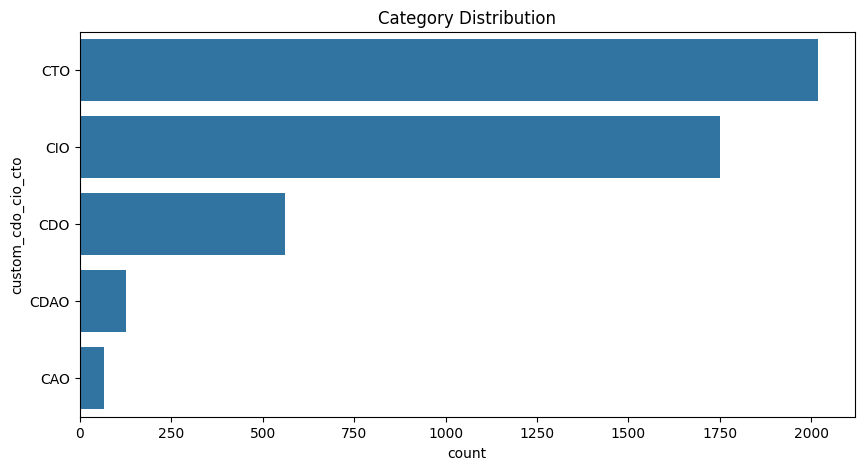

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(y=data['custom_cdo_cio_cto'], order=data['custom_cdo_cio_cto'].value_counts().index)
plt.title('Category Distribution')
plt.show()

In [ ]:
# Counting missing values in each column
missing_values = data.isnull().sum()

# Printing the count of missing values for each column
print(missing_values)

title                            7
custom_audience_persona          0
custom_cdo_cio_cto         2029933
dtype: int64


### Function to normalize abbreviations (3 to 7 characters, e.g., "C.T.O." → "CTO")

In [ ]:
DetectorFactory.seed = 0

def normalize_abbreviation(text):
    abbreviation_pattern = r'\b([A-Z])(?:[\.\s]?([A-Z])){2,6}\b'

    def clean_abbreviation(match):
        return match.group().replace(".", "").replace(" ", "")

    return re.sub(abbreviation_pattern, clean_abbreviation, text)

### Text Preprocessing

In [ ]:
def clean_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return "N/A"

    text = text.strip()

    try:
        detected_lang = detect(text)
        if detected_lang != 'en':
            text = GoogleTranslator(source=detected_lang, target='en').translate(text)
    except:
        pass

    text = normalize_abbreviation(text)

    text = text.lower()

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

### Applying cleaning

In [ ]:
# Applying the transformation to the dataset
data['processed_title'] = data['title'].apply(clean_text)

TypeError: expected string or bytes-like object, got 'NoneType'

### Label Encoding

In [ ]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['custom_c5'])

### Preparing Tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['processed_title'])
X = tokenizer.texts_to_sequences(data['processed_title'])
X = pad_sequences(X, maxlen=50)

y = tf.keras.utils.to_categorical(data['label'])

### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building LSTM Model

In [ ]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=50),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Recall'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Training the Model

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - Recall: 0.1384 - loss: 1.4624 - val_Recall: 0.7518 - val_loss: 0.5077
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - Recall: 0.8089 - loss: 0.4280 - val_Recall: 0.8644 - val_loss: 0.3577
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - Recall: 0.8869 - loss: 0.2805 - val_Recall: 0.8572 - val_loss: 0.3432
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - Recall: 0.9164 - loss: 0.2265 - val_Recall: 0.8752 - val_loss: 0.3155
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - Recall: 0.9332 - loss: 0.1788 - val_Recall: 0.8766 - val_loss: 0.3079


### Evaluating the model

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Recall: 0.8844 - loss: 0.2901
Test Accuracy: 87.66%


In [ ]:
from sklearn.metrics import recall_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Recall: {recall* 100:.2f}%")


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Recall: 89.24%


### Function for Classifying Test Titles

In [ ]:
def classify_title(title, threshold=0.9):
    cleaned_title = clean_text(title)
    seq = tokenizer.texts_to_sequences([cleaned_title])
    padded_seq = pad_sequences(seq, maxlen=50)
    pred = model.predict(padded_seq)[0]
    max_prob = np.max(pred)

    if max_prob < threshold:
        return "N/A"
    else:
        return label_encoder.inverse_transform([np.argmax(pred)])[0]

### Example Usage

In [ ]:
titles_df = pd.read_csv('titles.csv')
test_titles = titles_df.sample(frac=1/50000, random_state=42)

classifications = []
for title in test_titles['title']:
    classification = classify_title(title)
    classifications.append(classification)

test_titles['classification'] = classifications
test_titles.to_csv('test.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

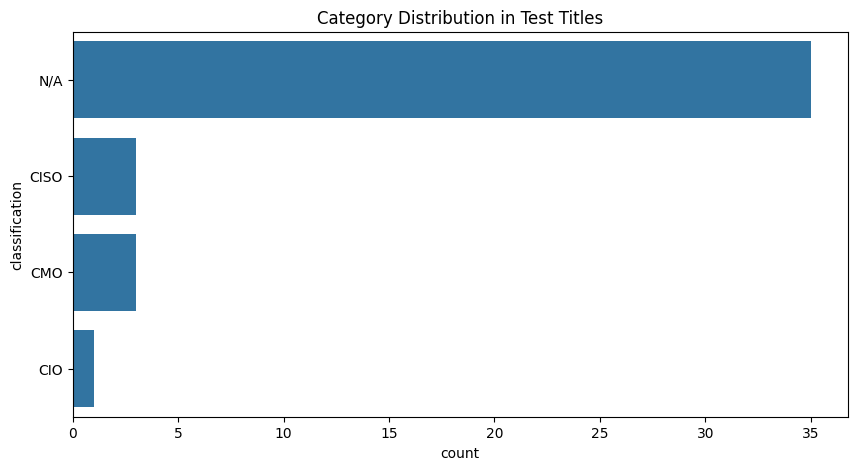

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(y=test_titles['classification'], order=test_titles['classification'].value_counts().index)
plt.title('Category Distribution in Test Titles')
plt.show()

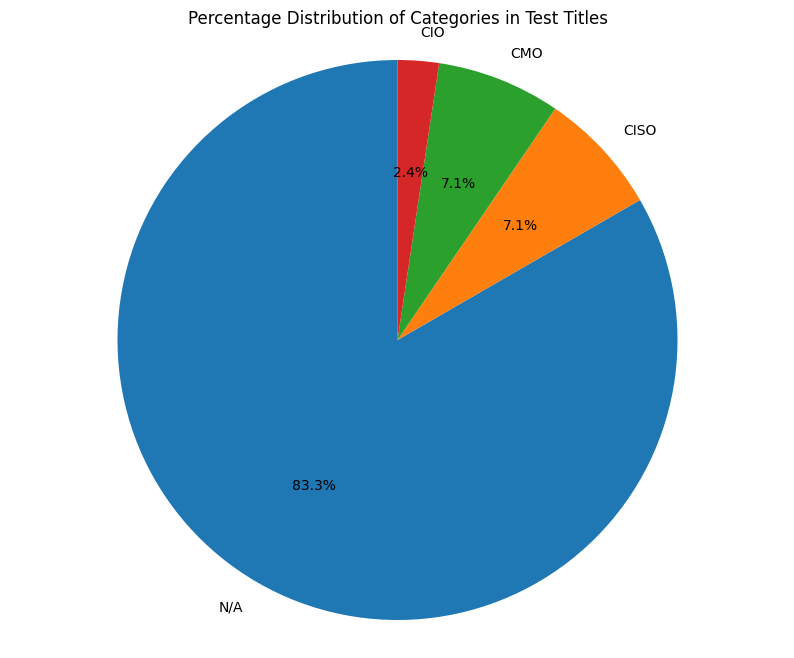

In [ ]:
category_counts = test_titles['classification'].value_counts()
category_percentages = (category_counts / category_counts.sum()) * 100

plt.figure(figsize=(10, 8))
plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=90)
plt.title('Percentage Distribution of Categories in Test Titles')
plt.axis('equal')
plt.show()


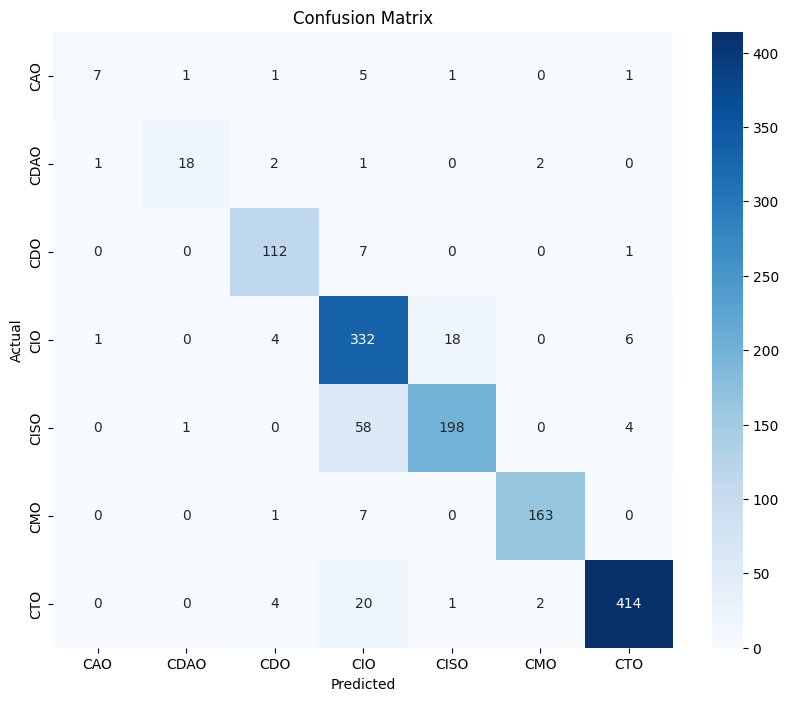

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Function to analyze individual misclassifications
def analyze_misclassifications(title, true_label, predicted_label, threshold=0.9):
    cleaned_title = clean_text(title)
    seq = tokenizer.texts_to_sequences([cleaned_title])
    padded_seq = pad_sequences(seq, maxlen=50)
    pred = model.predict(padded_seq)[0]
    max_prob = np.max(pred)
    predicted_class_index = np.argmax(pred)

    print(f"Title: {title}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Max Probability: {max_prob:.4f}")
    print(f"Probability Distribution: {dict(zip(label_encoder.classes_, pred))}")  #Show probabilities for all classes
    print("-" * 20)

In [ ]:
# Example usage:
misclassified_indices = np.where(y_true_classes != y_pred_classes)[0]
num_misclassified_to_analyze = min(10, len(misclassified_indices)) # Analyze a limited set for demonstration.
for i in misclassified_indices[:num_misclassified_to_analyze]:
    original_title = data.iloc[i]['title']
    true_label = label_encoder.inverse_transform([y_true_classes[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_classes[i]])[0]
    analyze_misclassifications(original_title, true_label, predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Title: chief risk officer (hong kong & greater china & north asia)
True Label: CTO
Predicted Label: CIO
Max Probability: 0.9912
Probability Distribution: {'CAO': 0.000646356, 'CDAO': 0.000101399855, 'CDO': 0.00016792602, 'CIO': 0.007189045, 'CISO': 0.99118036, 'CMO': 0.00060189865, 'CTO': 0.00011313094}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Title: ciso - americas division
True Label: CISO
Predicted Label: CIO
Max Probability: 0.9154
Probability Distribution: {'CAO': 0.0020316527, 'CDAO': 0.0004423988, 'CDO': 0.00046848526, 'CIO': 0.079730846, 'CISO': 0.9153692, 'CMO': 0.001532699, 'CTO': 0.00042468845}
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Title: chief risk officer, cs ltd (uk)
True Label: CDO
Predicted Label: CIO
Max Probability: 0.9875
Probability Distribution: {'CAO': 0.0007945135, 'CDAO': 0.00017364339, 'CDO': 0.00023241727, 'CIO': 0.010783646, 'CISO': 0.9874994, 'CMO': 0.00040499863, 'CTO': 0.000111411

In [ ]:
# Defining the keywords to search for
keywords = ['chief', 'cao', 'cdao', 'cdo', 'cio', 'ciso', 'cmo', 'cto']

# Counting the number of rows that match the criteria
count = 0
for index, row in data.iterrows():
    title = row['title'].lower()
    if any(keyword in title for keyword in keywords):
        count += 1

# Printing the results
print(f"Number of rows with the specified keywords in the title: {count}")
print(f"Out of a total of {len(data)} rows in the training dataset.")


Number of rows with the specified keywords in the title: 6856
Out of a total of 6970 rows in the training dataset.


In [ ]:
import re

# Defining the keywords and regular expressions
keywords = ['chief', 'president', 'head', 'founder', 'svp', 'vp']
regex_patterns = [r'c[a-zA-Z\s\.]{1,5}o', r'b[a-zA-Z\s\.]{1,5}o']

# Function to check if a title contains any of the keywords or regex patterns
def contains_keywords(title):
  title_lower = title.lower()
  if any(keyword in title_lower for keyword in keywords):
    return True
  for pattern in regex_patterns:
    if re.search(pattern, title_lower):
      return True
  return False

# Filtering the DataFrame
filtered_data = data[~data['title'].apply(contains_keywords)]

# Saving the filtered DataFrame to a CSV file
filtered_data.to_csv('filtered_titles.csv', index=False)

print(f"Number of rows without specified keywords: {len(filtered_data)}")
print("Filtered data saved to 'filtered_titles.csv'")


Number of rows without specified keywords: 5
Filtered data saved to 'filtered_titles.csv'
